In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

plt.rcParams['ytick.left']=False
plt.rcParams['xtick.bottom']=False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.labelbottom']=False
plt.rcParams['ytick.labelleft']=False


im = imageio.imread('img/cover.png')[:,:,0]


def get_sparse(X,missing,repl = np.nan):
    """
    Input:
    X [array] data matrix
    missing [float] percentage of missing entries
    repl [float] value assigned to missing entries
    
    Returns:
    X_incomplete [array] data matrix with missing entries set to repl
    missing_mask [array] boolean mask marking missing entries
    """
    
    size = np.size(X)
    missing_mask = np.array(size*[False])
    missing_mask[:int(missing*size)] = True
    np.random.shuffle(missing_mask)
    missing_mask = missing_mask.reshape(np.shape(X))
    
    X_incomplete = np.array(X,dtype=float)
    X_incomplete[missing_mask] = np.nan
    
    return X_incomplete, missing_mask



Using TensorFlow backend.


KNN Imputation
Imputing row 1/326 with 147 missing, elapsed time: 0.222
Imputing row 101/326 with 155 missing, elapsed time: 0.452
Imputing row 201/326 with 154 missing, elapsed time: 0.734
Imputing row 301/326 with 148 missing, elapsed time: 0.976
Nuclear Norm Minimization
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 595181
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 297869, constraints m = 496077
Cones:	linear vars: 297312
	sd vars: 198765, sd blks: 1
Setup time: 4.03e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
------------------------------------------

[SoftImpute] Iter 55: observed MAE=0.074256 rank=173
[SoftImpute] Iter 56: observed MAE=0.074245 rank=173
[SoftImpute] Iter 57: observed MAE=0.074236 rank=173
[SoftImpute] Iter 58: observed MAE=0.074228 rank=173
[SoftImpute] Iter 59: observed MAE=0.074221 rank=173
[SoftImpute] Iter 60: observed MAE=0.074214 rank=173
[SoftImpute] Iter 61: observed MAE=0.074205 rank=172
[SoftImpute] Iter 62: observed MAE=0.074197 rank=172
[SoftImpute] Iter 63: observed MAE=0.074190 rank=172
[SoftImpute] Iter 64: observed MAE=0.074184 rank=172
[SoftImpute] Iter 65: observed MAE=0.074178 rank=172
[SoftImpute] Iter 66: observed MAE=0.074173 rank=172
[SoftImpute] Iter 67: observed MAE=0.074166 rank=171
[SoftImpute] Iter 68: observed MAE=0.074159 rank=171
[SoftImpute] Iter 69: observed MAE=0.074152 rank=170
[SoftImpute] Iter 70: observed MAE=0.074145 rank=170
[SoftImpute] Iter 71: observed MAE=0.074140 rank=170
[SoftImpute] Iter 72: observed MAE=0.074135 rank=170
[SoftImpute] Iter 73: observed MAE=0.074130 ra

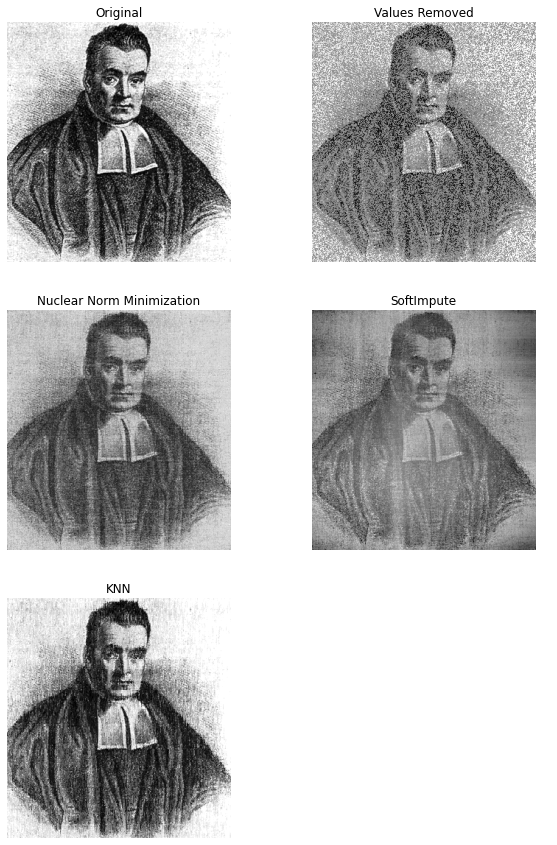

In [2]:
# Code curtesy of https://pypi.org/project/fancyimpute/

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from time import time

X = (im-np.mean(im))/np.std(im)

X_incomplete, missing_mask = get_sparse(X,missing=0.5)
T = {}

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
print("KNN Imputation")
t0 = time()
X_filled_knn = KNN(k=3).fit_transform(X_incomplete)
T['knn'] = time()-t0

# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
print("Nuclear Norm Minimization")
t0 = time()
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)
T['nnm'] = time()-t0

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
print("Soft Impute")
t0 = time()
X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)
T['softImpute'] = time()-t0




# print mean squared error for the  imputation methods above
nnm_mse = ((X_filled_nnm[missing_mask] - X[missing_mask]) ** 2).mean()
print("Nuclear norm minimization MSE: %f" % nnm_mse)

softImpute_mse = ((X_filled_softimpute[missing_mask] - X[missing_mask]) ** 2).mean()
print("SoftImpute MSE: %f" % softImpute_mse)

knn_mse = ((X_filled_knn[missing_mask] - X[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)

print(T)


fig, ax = plt.subplots(3,2,figsize=(10,15))

X_noisy = X_incomplete
X_incomplete[missing_mask] = 0


for a,x,title in zip(ax.flatten(),
                     [X,X_noisy,X_filled_nnm,X_filled_softimpute,X_filled_knn],
                     'Original,Values Removed,Nuclear Norm Minimization,SoftImpute,KNN'.split(',')):
    a.imshow(x,'gray')
    a.set_title(title)
    

plt.savefig('img/impute_05.png',bbox_inches='tight')

KNN Imputation
Imputing row 1/326 with 246 missing, elapsed time: 0.163
Imputing row 101/326 with 243 missing, elapsed time: 0.527
Imputing row 201/326 with 253 missing, elapsed time: 0.900
Imputing row 301/326 with 244 missing, elapsed time: 1.301
Nuclear Norm Minimization
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 535719
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 297869, constraints m = 496077
Cones:	linear vars: 297312
	sd vars: 198765, sd blks: 1
Setup time: 3.61e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
------------------------------------------

[SoftImpute] Iter 45: observed MAE=0.045204 rank=153
[SoftImpute] Iter 46: observed MAE=0.045160 rank=153
[SoftImpute] Iter 47: observed MAE=0.045096 rank=151
[SoftImpute] Iter 48: observed MAE=0.045048 rank=151
[SoftImpute] Iter 49: observed MAE=0.044989 rank=149
[SoftImpute] Iter 50: observed MAE=0.044928 rank=148
[SoftImpute] Iter 51: observed MAE=0.044877 rank=148
[SoftImpute] Iter 52: observed MAE=0.044848 rank=147
[SoftImpute] Iter 53: observed MAE=0.044807 rank=147
[SoftImpute] Iter 54: observed MAE=0.044782 rank=146
[SoftImpute] Iter 55: observed MAE=0.044730 rank=145
[SoftImpute] Iter 56: observed MAE=0.044690 rank=145
[SoftImpute] Iter 57: observed MAE=0.044661 rank=144
[SoftImpute] Iter 58: observed MAE=0.044627 rank=144
[SoftImpute] Iter 59: observed MAE=0.044589 rank=143
[SoftImpute] Iter 60: observed MAE=0.044557 rank=142
[SoftImpute] Iter 61: observed MAE=0.044503 rank=141
[SoftImpute] Iter 62: observed MAE=0.044468 rank=141
[SoftImpute] Iter 63: observed MAE=0.044447 ra

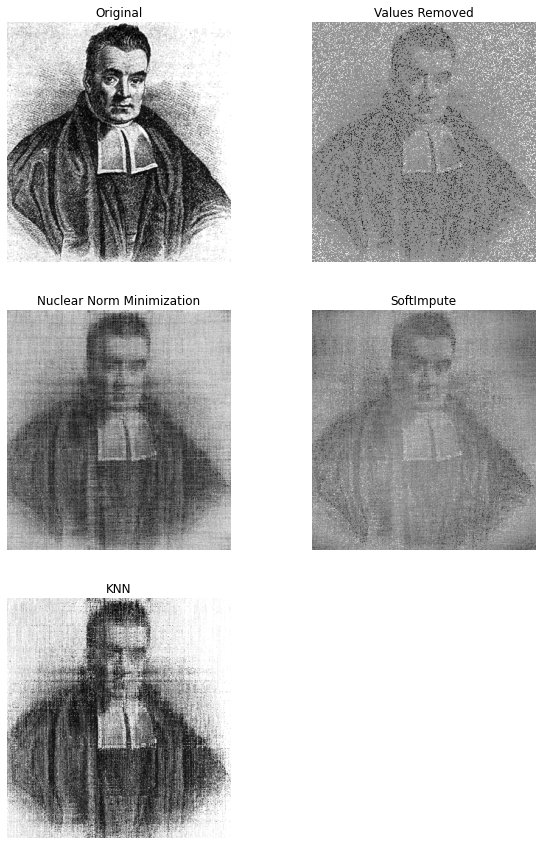

In [3]:
# Code curtesy of https://pypi.org/project/fancyimpute/

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from time import time

X = (im-np.mean(im))/np.std(im)

X_incomplete, missing_mask = get_sparse(X,missing=0.8)
T = {}

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
print("KNN Imputation")
t0 = time()
X_filled_knn = KNN(k=3).fit_transform(X_incomplete)
T['knn'] = time()-t0

# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
print("Nuclear Norm Minimization")
t0 = time()
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)
T['nnm'] = time()-t0

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
print("Soft Impute")
t0 = time()
X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)
T['softImpute'] = time()-t0




# print mean squared error for the  imputation methods above
nnm_mse = ((X_filled_nnm[missing_mask] - X[missing_mask]) ** 2).mean()
print("Nuclear norm minimization MSE: %f" % nnm_mse)

softImpute_mse = ((X_filled_softimpute[missing_mask] - X[missing_mask]) ** 2).mean()
print("SoftImpute MSE: %f" % softImpute_mse)

knn_mse = ((X_filled_knn[missing_mask] - X[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)

print(T)


fig, ax = plt.subplots(3,2,figsize=(10,15))

X_noisy = X_incomplete
X_incomplete[missing_mask] = 0


for a,x,title in zip(ax.flatten(),
                     [X,X_noisy,X_filled_nnm,X_filled_softimpute,X_filled_knn],
                     'Original,Values Removed,Nuclear Norm Minimization,SoftImpute,KNN'.split(',')):
    a.imshow(x,'gray')
    a.set_title(title)

    
plt.savefig('img/impute_08.png',bbox_inches='tight')